In [174]:
!git clone https://github.com/MinkyuRamen/hackaton_1128.git

fatal: destination path 'hackaton_1128' already exists and is not an empty directory.


In [175]:
import pandas as pd
y = pd.read_csv("/content/hackaton_1128/preprocess_data/한국출생아.csv", index_col = 0)

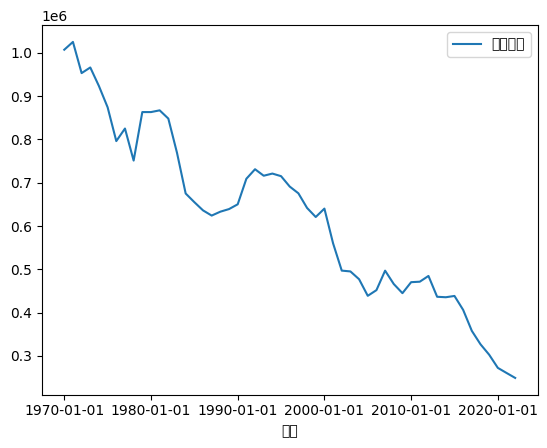

In [176]:
import matplotlib.pyplot as plt
y.plot()
plt.show()

In [177]:
y.head()

,출생아수
시점,
1970-01-01,1007000.0
1971-01-01,1025000.0
1972-01-01,953000.0
1973-01-01,966000.0
1974-01-01,923000.0


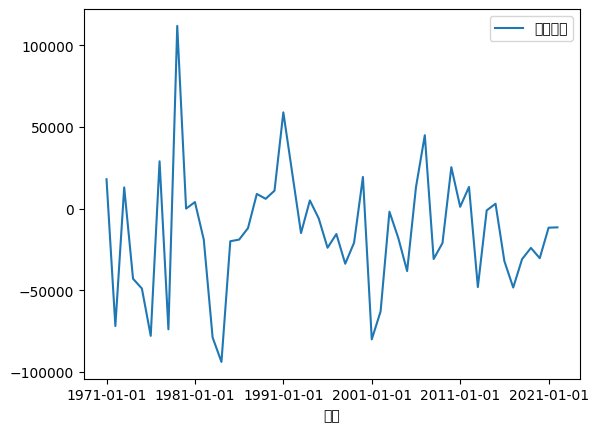

In [178]:
stationary_y = y.diff().dropna() # ADF Test 결과 stationary
stationary_y.plot()
plt.show()

In [179]:
pip install QuantLib-Python

In [180]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from QuantLib import *

In [181]:
ydat = np.array(stationary_y)

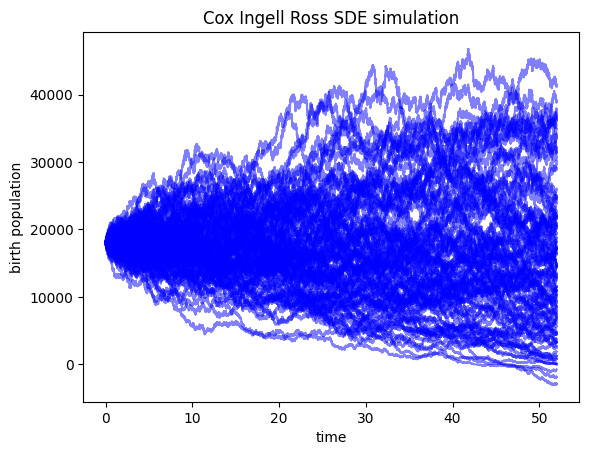

In [182]:
import numpy as np
import matplotlib.pyplot as plt

# CIR 모형의 시간에 따라 변하는 파라미터를 정의하는 함수
def alpha_t(t, r, k):
    return r + k * t

# CIR 모형 시뮬레이션을 위한 함수
def simulate_cir_population(T, num_steps, num_simulations, initial_population, params):
    r, k, mu, sigma = params
    dt = T / num_steps
    t_values = np.linspace(0, T, num_steps + 1)

    # 각 시뮬레이션에서의 결과를 저장할 배열
    population_all = np.zeros((num_simulations, num_steps + 1))

    for j in range(num_simulations):
        population = np.zeros(num_steps + 1)
        population[0] = initial_population

        for i in range(num_steps):
            alpha = alpha_t(t_values[i], r, k)
            dW = np.random.normal(0, np.sqrt(dt))
            population[i + 1] = (
                population[i] + alpha * (mu - population[i] / initial_population) * dt + sigma * np.sqrt(abs(population[i])) * dW
            )

        population_all[j, :] = population

    return population_all

# 파라미터 설정
T = 52
num_steps = 52*365 # dt
num_simulations = 100 # number of sample
initial_population = 18000  # 초기 인구

r0 = -0.1  # 초기 증가율
k0 = -2  # 시간에 따른 증가율
mu0 = 2 # 평균
sigma0 = 10  # 변동성
init_params = [r0, k0, mu0, sigma0]

t_values = np.linspace(0, T, num_steps + 1) # year
T_values = np.linspace(52+1, num_steps, 52).astype(int) # real


# CIR 모형 시뮬레이션
population_all = simulate_cir_population(T, num_steps, num_simulations, initial_population, init_params)

# 결과 시각화 (시뮬레이션 결과 중 5개만 표시)
for j in range(num_simulations):
    plt.plot(t_values, population_all[j, :], label=f'Simulation {j + 1}', color = "blue", alpha = 0.5)

plt.title('Cox Ingell Ross SDE simulation')
plt.xlabel('time')
plt.ylabel('birth population')
plt.show()

In [183]:
population_all[:,T_values].shape

(100, 52)

In [184]:
# optimization
# result = minimize(lambda params: -np.sum((np.mean(simulate_cir_population(T, num_steps, num_simulations, initial_population, params))[:,T_values] - stationary_y['출생아수'].values)**2), init_params, method = "BFGS")

In [185]:
stationary_y.tail()

,출생아수
시점,
2018-01-01,-31000.0
2019-01-01,-24100.0
2020-01-01,-30400.0
2021-01-01,-11700.0
2022-01-01,-11500.0


In [186]:
# extract the optimized hyper-parameters
# r_fit, k_fit, mu_fit, sigma_fit = result.x

# print the estimated parameters
# print(f"Estimated r + k*t (alpha(t)) : {r_fit, k_fit}")
# print(f"Estimated mu : {mu_fit}")
# print(f"Estimated sigma : {sigma_fit}")

# simulate CIR process for the next 50 times steps(500 samples)
future_steps = 50
predicted_data_samples_cir = simulate_cir_population(future_steps,
                                                     num_steps = future_steps*365,
                                                     num_simulations = 1000,
                                                     initial_population = -11500.0,
                                                     params = init_params)

In [187]:
predicted_data_samples_cir.shape

(1000, 18251)

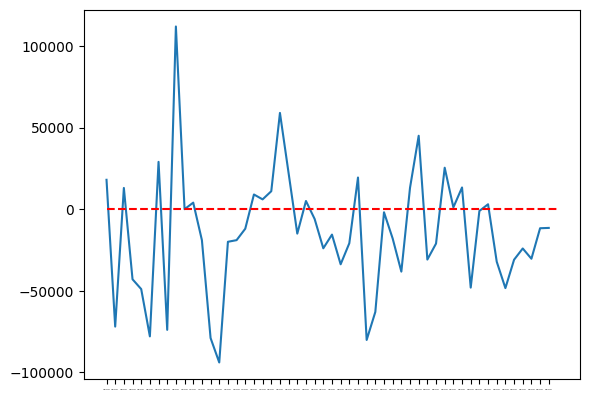

In [254]:
# Plot the original data and the mean of predicted CIR values
plt.plot(stationary_y.index, stationary_y['출생아수'], label='Original Data')
plt.hlines(y=0, xmin = 0, xmax = 52, color = "red", linestyles="--")
plt.xticks(fontsize = 0)
plt.show()

In [189]:
t_values_pred = np.linspace(1, future_steps, future_steps*365+1)

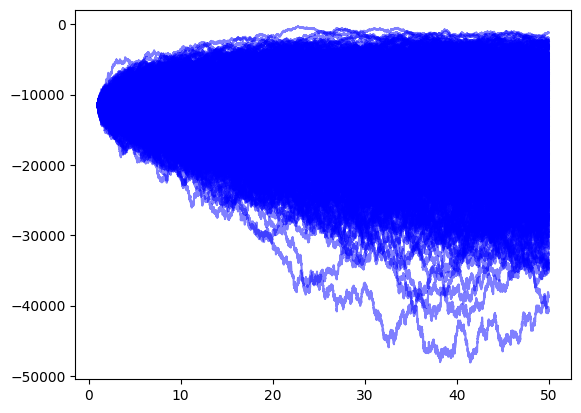

In [190]:
for j in range(1000):
    plt.plot(t_values_pred, predicted_data_samples_cir[j, :], label=f'Simulation {j + 1}', color = "blue", alpha = 0.5)

Text(0.5, 1.0, 'Stochastic Process of BIRTH POPULATION 50 years with daily update')

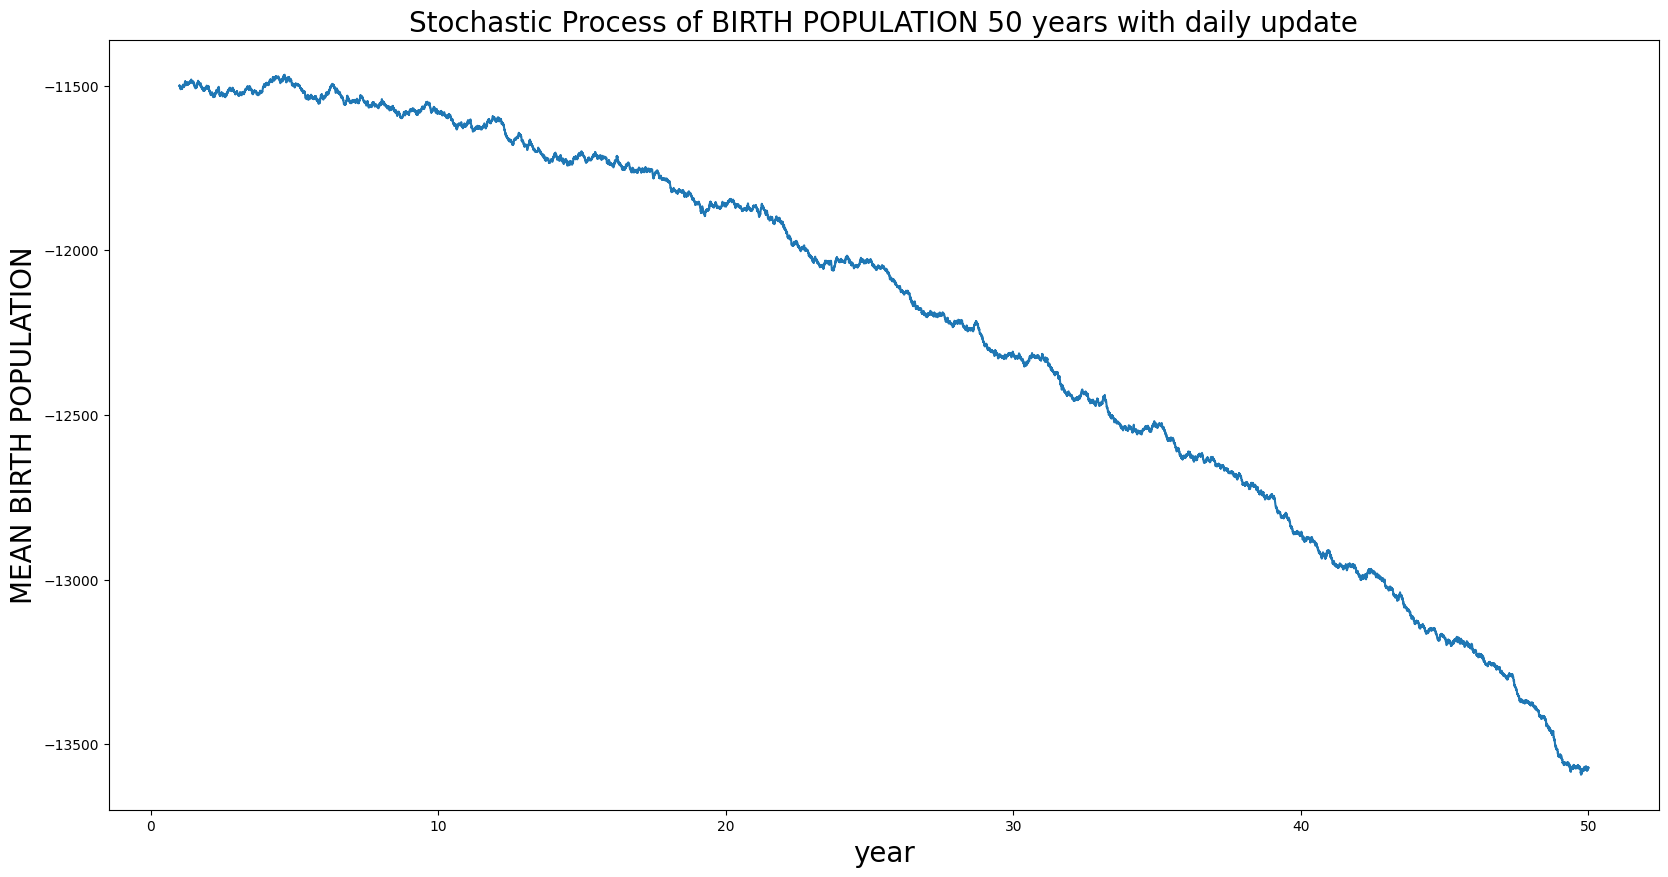

In [191]:
plt.figure(figsize = (20,10))
plt.plot(t_values_pred, np.mean(predicted_data_samples_cir, axis = 0))
plt.xlabel("year", fontsize = 20)
plt.ylabel("MEAN BIRTH POPULATION", fontsize = 20)
plt.title("Stochastic Process of BIRTH POPULATION 50 years with daily update", fontsize = 20)

In [241]:
y_diff = np.mean(predicted_data_samples_cir, axis = 0)
ydiff = y_diff[T_values_pred]

<Axes: >

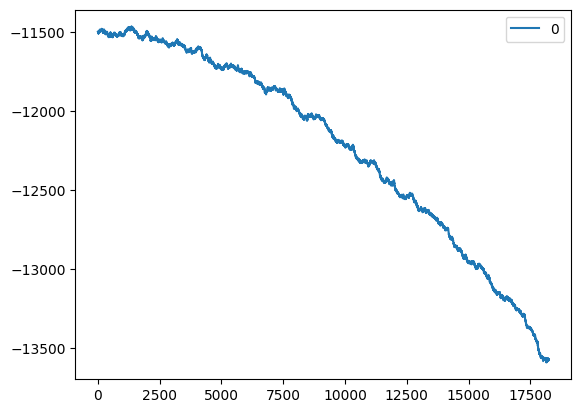

In [230]:
pd.DataFrame(y_diff).plot()

In [218]:
type(y_diff)

numpy.ndarray

In [233]:
y['출생아수'].iloc[-1]

249100.0

In [235]:
pd.DataFrame(y_diff)

,0
0,-11500.000000
1,-11500.143365
2,-11501.079483
3,-11501.011427
4,-11500.633879
...,...
18246,-13573.992673
18247,-13574.262930
18248,-13571.240585
18249,-13572.099217


In [243]:
raw_y = np.r_[y['출생아수'].iloc[-1], ydiff].cumsum()[1:]

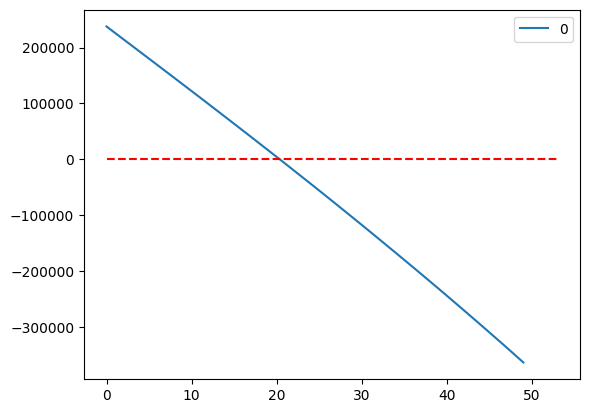

In [259]:
pd.DataFrame(raw_y).plot()
plt.hlines(y = 0, xmin = 0, xmax = 53, color = "red", linestyle = "--")
plt.title()

Text(0.5, 1.0, 'Stochastic Process of BIRTH POPULATION 50 years with daily update (median)')

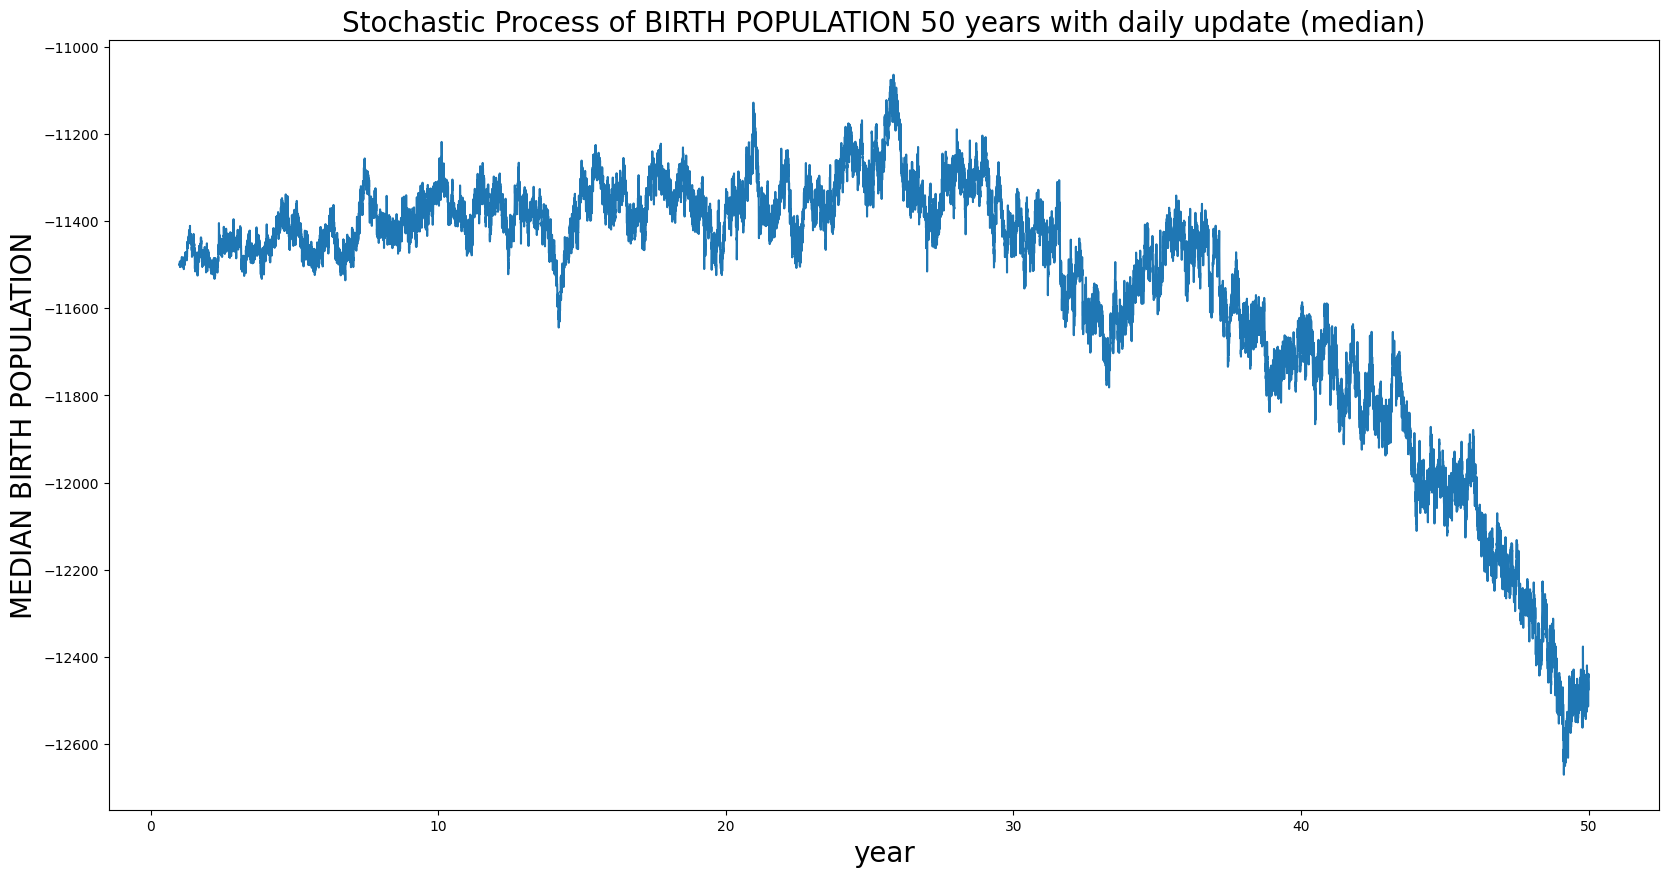

In [192]:
plt.figure(figsize = (20,10))
plt.plot(t_values_pred, np.median(predicted_data_samples_cir, axis = 0))
plt.xlabel("year", fontsize = 20)
plt.ylabel("MEDIAN BIRTH POPULATION", fontsize = 20)
plt.title("Stochastic Process of BIRTH POPULATION 50 years with daily update (median)", fontsize = 20)

In [193]:
T_values_pred = np.linspace(future_steps+1, future_steps*365, future_steps).astype(int)

In [194]:
T_values_pred.__len__()

50

In [195]:
predicted_data_samples_cir[:,T_values_pred].shape

(1000, 50)

In [196]:
T_values_pred[9]

3393

<Axes: ylabel='Density'>

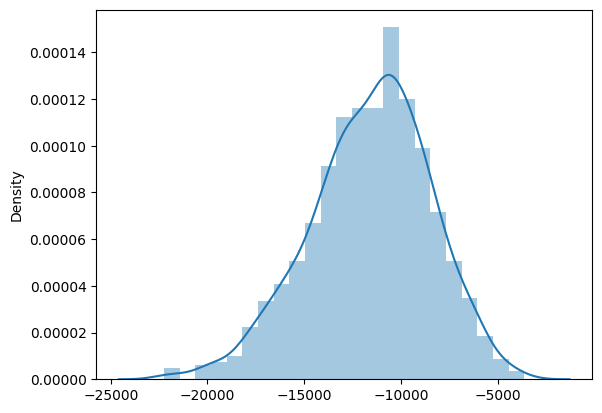

In [197]:
# 10 year future distribution for next day
year10pred = predicted_data_samples_cir[:,T_values_pred[9]]
import seaborn as sns
sns.distplot(year10pred)

# Different Optimization (robust to initial parameter setting)


In [ ]:
# optimization
# result_CG = minimize(lambda params: -np.sum((simulate_cir_population(T, num_steps, num_simulations, initial_population, params)[:,T_values] - stationary_y['출생아수'].values)**2), init_params, method = "CG")

In [ ]:
# # extract the optimized hyper-parameters
# r_fit2, k_fit2, mu_fit2, sigma_fit2 = result_CG.x

# # print the estimated parameters
# print(f"Estimated r + k*t (alpha(t)) : {r_fit2, k_fit2}")
# print(f"Estimated mu : {mu_fit2}")
# print(f"Estimated sigma : {sigma_fit2}")

# # simulate CIR process for the next 50 times steps(500 samples)
# future_steps = 50
# predicted_data_samples_cir2 = simulate_cir_population(future_steps,
#                                                      num_steps = future_steps*365,
#                                                      num_simulations = 1000,
#                                                      initial_population = -11500.0,
#                                                      params = [r_fit2, k_fit2, mu_fit2, sigma_fit2])

In [ ]:
# for j in range(1000):
#     plt.plot(t_values_pred, predicted_data_samples_cir2[j, :], label=f'Simulation {j + 1}', color = "blue", alpha = 0.5)

In [ ]:
# plt.figure(figsize = (20,10))
# plt.plot(t_values_pred, np.mean(predicted_data_samples_cir2, axis = 0))
# plt.xlabel("year", fontsize = 20)
# plt.ylabel("MEAN BIRTH POPULATION ", fontsize = 20)
# plt.title("Stochastic Process of BIRTH POPULATION 50 year s-  Optim option: CG", fontsize = 20)

In [ ]:
# plt.figure(figsize = (20,10))
# plt.plot(t_values_pred, np.median(predicted_data_samples_cir2, axis = 0))
# plt.xlabel("year", fontsize = 20)
# plt.ylabel("MEDIAN BIRTH POPULATION", fontsize = 20)
# plt.title("Stochastic Process of BIRTH POPULATION 50 years with daily update (median)", fontsize = 20)

# RKHS(banned)

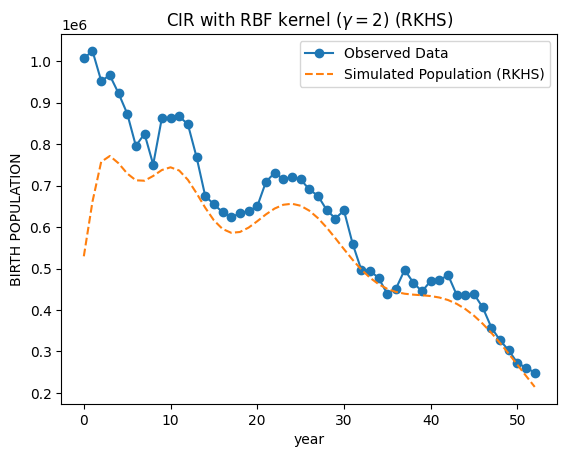

In [201]:
import numpy as np
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt

# CIR 모형의 시간에 따라 변하는 파라미터를 정의하는 함수
def alpha_t(t, r, k):
    return r + k * t

# CIR 모형 시뮬레이션 함수 (인구 예측용으로 수정)
def simulate_cir_population_(T, num_steps, initial_population, r, k, sigma):
    dt = T / num_steps
    t_values = np.linspace(0, T, num_steps + 1)

    # 결과를 저장할 배열
    population = np.zeros(num_steps + 1)
    population[0] = initial_population

    for i in range(num_steps):
        alpha = alpha_t(t_values[i], r, k)
        dW = np.random.normal(0, np.sqrt(dt))
        population[i + 1] = (
            population[i] + alpha * (1 - population[i] / initial_population) * dt + sigma * np.sqrt(abs(population[i])) * dW
        )

    return t_values, population

# 관찰된 데이터
observed_data = np.array(y)

# 초기 추정값 설정
initial_guess = [0.01, 0.0001, 0.1]  # r, k, sigma

# CIR 모형 시뮬레이션 결과를 사용하여 특징 매핑 함수를 생성
def feature_mapping(t_values, r, k, sigma):
    features = np.zeros((len(t_values), 3))
    for i, t in enumerate(t_values):
        alpha = alpha_t(t, r, k)
        features[i, 0] = alpha
        features[i, 1] = np.sqrt(t)
        features[i, 2] = sigma * np.sqrt(t)
    return features

# CIR 모델 학습 및 시뮬레이션
T = len(observed_data) - 1
num_steps = T
initial_population = observed_data[0]

# 특징 매핑
features = feature_mapping(np.arange(T + 1), *initial_guess)

# 커널 트릭을 사용하여 Kernel Ridge Regression 모델 생성
kernel_ridge_model = KernelRidge(kernel='rbf', gamma=2)
kernel_ridge_model.fit(features, observed_data)

# 시뮬레이션 결과 예측
t_values_sim, _ = simulate_cir_population_(T, num_steps, initial_population, *initial_guess)
features_sim = feature_mapping(t_values_sim, *initial_guess)
population_pred = kernel_ridge_model.predict(features_sim)

# 시뮬레이션 결과 시각화
plt.plot(np.arange(T + 1), observed_data, label='Observed Data', marker='o')
plt.plot(np.arange(T + 1), population_pred, label='Simulated Population (RKHS)', linestyle='--')
plt.title('CIR with RBF kernel ($\gamma=2$) (RKHS)')
plt.xlabel('year')
plt.ylabel('BIRTH POPULATION')
plt.legend()
plt.show()


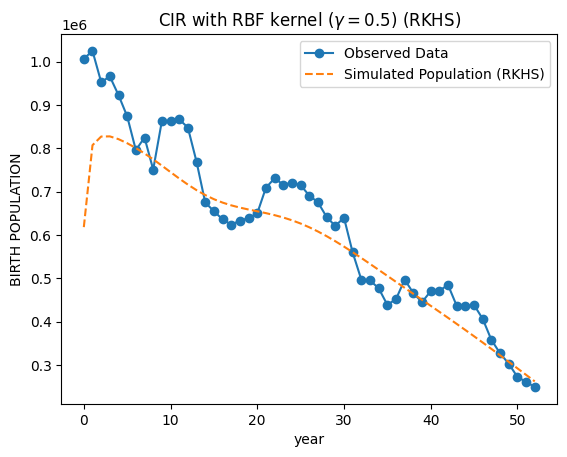

In [204]:
import numpy as np
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt

# CIR 모형의 시간에 따라 변하는 파라미터를 정의하는 함수
def alpha_t(t, r, k):
    return r + k * t

# CIR 모형 시뮬레이션 함수 (인구 예측용으로 수정)
def simulate_cir_population_(T, num_steps, initial_population, r, k, sigma):
    dt = T / num_steps
    t_values = np.linspace(0, T, num_steps + 1)

    # 결과를 저장할 배열
    population = np.zeros(num_steps + 1)
    population[0] = initial_population

    for i in range(num_steps):
        alpha = alpha_t(t_values[i], r, k)
        dW = np.random.normal(0, np.sqrt(dt))
        population[i + 1] = (
            population[i] + alpha * (1 - population[i] / initial_population) * dt + sigma * np.sqrt(abs(population[i])) * dW
        )

    return t_values, population

# 관찰된 데이터
observed_data = np.array(y)

# 초기 추정값 설정
initial_guess = [0.01, 0.0001, 0.1]  # r, k, sigma

# CIR 모형 시뮬레이션 결과를 사용하여 특징 매핑 함수를 생성
def feature_mapping(t_values, r, k, sigma):
    features = np.zeros((len(t_values), 3))
    for i, t in enumerate(t_values):
        alpha = alpha_t(t, r, k)
        features[i, 0] = alpha
        features[i, 1] = np.sqrt(t)
        features[i, 2] = sigma * np.sqrt(t)
    return features

# 주기적 커널을 사용한 커널 리지 회귀 모델 생성
kernel_ridge_model = KernelRidge(kernel='rbf', gamma = 0.5)

# CIR 모델 학습 및 시뮬레이션
T = len(observed_data) - 1
num_steps = T
initial_population = observed_data[0]

# 특징 매핑
features = feature_mapping(np.arange(T + 1), *initial_guess)

# 커널 트릭을 사용하여 Kernel Ridge Regression 모델 생성
kernel_ridge_model.fit(features, observed_data)

# 시뮬레이션 결과 예측
t_values_sim, _ = simulate_cir_population_(T, num_steps, initial_population, *initial_guess)
features_sim = feature_mapping(t_values_sim, *initial_guess)
population_pred = kernel_ridge_model.predict(features_sim)

# 시뮬레이션 결과 시각화
plt.plot(np.arange(T + 1), observed_data, label='Observed Data', marker='o')
plt.plot(np.arange(T + 1), population_pred, label='Simulated Population (RKHS)', linestyle='--')
plt.title('CIR with RBF kernel ($\gamma=0.5$) (RKHS)')
plt.xlabel('year')
plt.ylabel('BIRTH POPULATION')
plt.legend()
plt.show()



In [75]:
import numpy as np
from scipy.optimize import minimize_scalar

# 주어진 데이터
y_data = np.array(y)

# Lipschitz 연속성을 만족하는 함수 생성
def lipschitz_continuous_function(x, y_data, lipschitz_constant):
    def lipschitz_function(t):
        # 목적 함수: 주어진 데이터와의 차이의 제곱의 합
        difference = y_data - t
        return np.sum(difference**2) + lipschitz_constant * np.sum(np.abs(x - t))

    # 최적화 문제를 푸는 함수
    result = minimize_scalar(lipschitz_function, bounds=(min(y_data), max(y_data)), method='bounded')
    optimal_input = result.x
    return optimal_input

# Lipschitz 연속성을 만족하는 함수 생성
lipschitz_constant = 2  # Lipschitz 상수
optimal_input = lipschitz_continuous_function(y_data, y_data, lipschitz_constant)

print("Optimal Input for Lipschitz Function:", optimal_input)


Optimal Input for Lipschitz Function: 621537.8679018544


In [205]:
init_params

[-0.1, -2, 2, 10]

# Goodness of FIt Test for SDE model

In [213]:
# for purpose of goodness of fit test
# with comparison of given data
population_fit_discretized = simulate_cir_population(T, num_steps, num_simulations, initial_population, init_params)[:,T_values]

IndexError: ignored

In [ ]:
import re
import scipy.stats
from scipy.stats import chi2

import math
import warnings
import statsmodels.api as sm
import pylab as py
warnings.filterwarnings('ignore')

def gof_test(o, e, obs_num=T, alpha = 0.05):
  """
  for given SDE with fitted hyper-parameters,
  perform Chi-Square Goodenss of Fit Test within data

  for testing, we use mean function of SDE simulation

  Observation is SDE in discretized values
  Expectation is data
  """
  # test statistic
  o = population_fit_discretized
  e = stationary_y['출생아수'].values
  chi = ((o-e)^2)/e
  # df
  param_size = 4 # r, k, mu, sigma
  df = (obs_num -1) -param_size -1
  if chi2.ppf(0.05, df)< chi < chi2.ppf(0.95, df):
    print("Goodness of Fit Test Passed")
  else:
    print("Goodness of Fit Test Failed")

In [ ]:
population_fit_discretized.shape

In [ ]:
mean_fit_discretized = np.mean(population_fit_discretized, axis=0)

In [ ]:
err = (mean_fit_discretized - stationary_y['출생아수'].values)

In [ ]:
stationary_y['출생아수'].values

In [ ]:
err.shape

In [ ]:
err*err

In [ ]:
e2 = err*err

In [ ]:
aa = abs(stationary_y['출생아수'].values + 0.000000001)

In [ ]:
res = np.delete((e2/aa),9)

In [207]:
Chi2 = np.sum(res)
df = T-1 -len(init_params) - 1
print(Chi2)

3678693.7889547586


In [208]:
(err*err).shape

(52,)

In [209]:
chi2.ppf(0.95, 100000)

100736.736177319

In [210]:
# H0 : Model Fits well with the data(label. hypothesis)
if chi2.ppf(0.05, df)< Chi2 < chi2.ppf(0.95, df):
  print("Goodness of Fit Test Passed")
else:
  print("Goodness of Fit Test Failed : Model does not fit well with the data")

Goodness of Fit Test Failed : Model does not fit well with the data


In [211]:
# gof_test(mean_fit_discretized, stationary_y['출생아수'].values, 0.05, 0.95)